[init] For pH0 = 7.36, strong-ion net (Na+ - Cl-) = 0.0000 M
[████████████████████████████████████████] time 100.000% | conv~100.000%
Finished at t = 251086.3 s when S < 0.0001% of S0.
Data → simulation_results.csv; figures saved as PNGs.


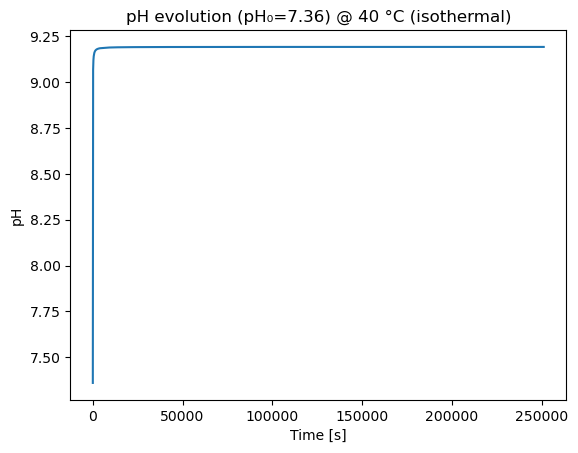

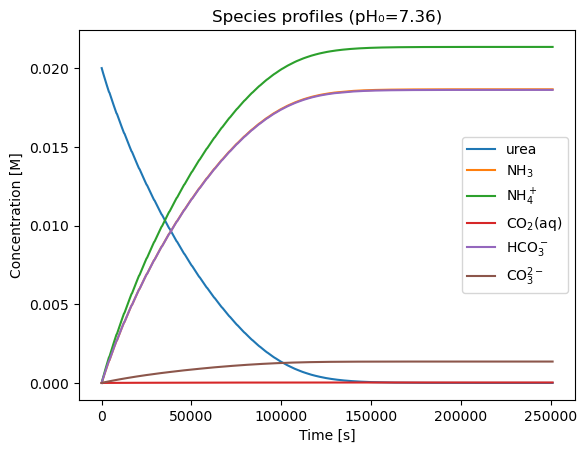

In [30]:
# Urease–urea batch reactor @ 40 °C (default isothermal), with optional
# unit-correct energy balance (adiabatic/jacketed), optional competitive
# phosphate inhibition, ASCII progress bar, and user-set INITIAL pH via a
# conserved strong-ion background (Na+ - Cl-).

import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar

# ╔══════════════════════════════════════════════════════════════╗
# ║                       USER SETTINGS                          ║
# ╚══════════════════════════════════════════════════════════════╝

# Volume & enzyme loading
volume_L               = 0.2          # reactor liquid volume [L]
grams_urease_powder    = 0.1         # mass of (effective) urease powder [g]
powder_activity_frac   = 1         # 0–1 scale for purity/activity
E_loading_g_per_L      = grams_urease_powder * powder_activity_frac / volume_L  # g/L

# Initial pH control (set None to disable)
initial_pH             = 7.36         # e.g., 6.0, 7.2, 8.5, or None

# Temperature control
isothermal             = True         # True: fixed 40 °C; False: simulate T
fixed_temperature_K    = 313.15       # 40 °C

# If isothermal == False, choose adiabatic/jacketed energy balance
adia                   = True         # only used if isothermal=False
UA_W_per_K             = 100.0        # overall U*A [W/K], if jacketed
T_jacket_K             = 313.15       # jacket temperature [K]
rho_kg_per_L           = 1.0          # per-liter basis
Cp_J_per_kgK           = 4184.0       # water cp
deltaH_J_per_mol       = -70.5e3      # reaction enthalpy (exothermic, keep negative)

# Chemistry: initial totals (no CO₂ steering)
S0                     = 0.020        # urea [M] (20 mM)
N0                     = 0.0          # total ammonia [M]
C0                     = 0.0          # total inorganic carbon [M]
Pt_total_M             = 0.0          # total phosphate [M]; 0.0 = no phosphate

# Time control
auto_finish            = True         # stop when urea ~depleted
urea_cut_frac          = 1e-6         # stop when S < urea_cut_frac * S0
t_final_s              = 2200         # used only if auto_finish=False
n_points               = 1500         # samples written to CSV/plots

# Progress bar
show_progress          = True         # tqdm-like ASCII bar in terminal
progress_chunks        = 60           # number of chunks printed in bar

# Output
make_plots             = True
csv_path               = "simulation_results.csv"

# ╔══════════════════════════════════════════════════════════════╗
# ║                  CONSTANTS & PARAMETERS                      ║
# ╚══════════════════════════════════════════════════════════════╝

R   = 8.314  # J/mol/K

# Kinetics from Qin & Cabral (1994), per gram of enzyme
k0_mol_per_s_per_g = 0.267  # mol NH3/(s·g)
Ea    = 29.1e3                 # J/mol
KM, Ks = 2.56e-3, 6.18         # M

# pH-activity (two-site)
pKa_es1, pKa_es2 = 9.07, 5.62
Kes1, Kes2 = 10**(-pKa_es1), 10**(-pKa_es2)
alpha_e, beta_e = 0.373, 0.564

# ── FIX: Product inhibition Kp(pH) from Qin & Cabral (1994), table-based, clamped
# Points: (pH, Kp [M]); Kp is ~independent of T up to 40 °C in their data.
_KP_POINTS = [
    (6.25, 0.1785),
    (6.50, 0.1194),
    (7.00, 0.0693),
    (7.50, 0.0386),
    (8.00, 0.0311),
    (8.50, 0.0327),
    (8.75, 0.0298),
    (9.00, 0.0310),
]

def Kp_of_pH(pH):
    """Positive, data-driven Kp(pH) with endpoint clamping and linear interpolation."""
    pts = _KP_POINTS
    if pH <= pts[0][0]:
        return pts[0][1]
    if pH >= pts[-1][0]:
        return pts[-1][1]
    for (pa, Ka), (pb, Kb) in zip(pts, pts[1:]):
        if pa <= pH <= pb:
            w = (pH - pa) / (pb - pa)
            return Ka + w * (Kb - Ka)
    # Fallback (shouldn't hit)
    return pts[-1][1]

# Optional competitive phosphate inhibition (H2PO4- + HPO4^2- as “active”)
Ki_phosphate = 0.010  # [M] — tune to data; large → negligible inhibition

# Acid–base constants (held fixed; fine for 40 °C isothermal)
Kw     = 1e-14            # water autoprotolysis
Ka_NH4 = 5.62e-10         # NH4+ ⇌ NH3 + H+
Ka1    = 4.45e-7          # H2CO3 ⇌ HCO3– + H+
Ka2    = 4.69e-11         # HCO3– ⇌ CO3^2–
# Phosphate triprotic
Ka1p   = 7.11e-3          # H3PO4 ⇌ H2PO4– + H+
Ka2p   = 6.32e-8          # H2PO4– ⇌ HPO4^2– + H+
Ka3p   = 4.22e-13         # HPO4^2– ⇌ PO4^3–

# ╔══════════════════════════════════════════════════════════════╗
# ║       INITIAL pH: STRONG-ION BACKGROUND (Na+ - Cl-)          ║
# ╚══════════════════════════════════════════════════════════════╝

B_STRONG = 0.0  # net strong-ion background [M], conserved

def _B_for_target_pH(pH_target, Ntot, Ctot, Ptot):
    """Compute net strong-ion background (Na+ - Cl-) [M] that yields pH_target
       for given totals under electroneutrality."""
    H  = 10**(-pH_target)
    OH = Kw / H

    NH4 = Ntot * (H / (H + Ka_NH4))

    denom_c = H*H + Ka1*H + Ka1*Ka2
    HCO3 = Ctot * (Ka1 * H / denom_c)
    CO3  = Ctot * (Ka1 * Ka2 / denom_c)

    Dp   = H**3 + Ka1p*H**2 + Ka1p*Ka2p*H + Ka1p*Ka2p*Ka3p
    H2PO4 = Ptot * (Ka1p * H**2 / Dp)
    HPO4  = Ptot * (Ka1p * Ka2p * H / Dp)
    PO4   = Ptot * (Ka1p * Ka2p * Ka3p / Dp)

    # From electroneutrality: (H + NH4 + Na+) = (OH + HCO3 + 2CO3 + H2PO4 + 2HPO4 + 3PO4 + Cl-)
    # Let B = [Na+] - [Cl-]. Rearranged: B = RHS - LHS (without Na+/Cl-).
    B = (OH + HCO3 + 2*CO3 + H2PO4 + 2*HPO4 + 3*PO4) - (H + NH4)
    return B

# ╔══════════════════════════════════════════════════════════════╗
# ║              SPECIATION & pH  (charge balance)               ║
# ╚══════════════════════════════════════════════════════════════╝

_SPEC_LAST_LOGH = {"val": 7.0}  # warm start for root bracketing

def _charge_balance(logH, Ntot, Ctot, Ptot):
    H  = 10**(-logH)
    OH = Kw / H

    # ammonia
    NH4 = Ntot * (H / (H + Ka_NH4))

    # carbonate
    denom_c = H*H + Ka1*H + Ka1*Ka2
    HCO3 = Ctot * (Ka1 * H / denom_c)
    CO3  = Ctot * (Ka1 * Ka2 / denom_c)

    # phosphate
    Dp   = H**3 + Ka1p*H**2 + Ka1p*Ka2p*H + Ka1p*Ka2p*Ka3p
    H2PO4 = Ptot * (Ka1p * H**2 / Dp)
    HPO4  = Ptot * (Ka1p * Ka2p * H / Dp)
    PO4   = Ptot * (Ka1p * Ka2p * Ka3p / Dp)

    # electroneutrality INCLUDING strong-ion background B_STRONG
    return (H + NH4) - (OH + HCO3 + 2*CO3 + H2PO4 + 2*HPO4 + 3*PO4) + B_STRONG

def compute_speciation(Ntot, Ctot, Ptot):
    """Return dict with pH and species for given totals."""
    Ntot = max(Ntot, 0.0); Ctot = max(Ctot, 0.0); Ptot = max(Ptot, 0.0)

    lo = max(1.0, _SPEC_LAST_LOGH["val"] - 3.0)
    hi = min(13.0, _SPEC_LAST_LOGH["val"] + 3.0)
    f_lo = _charge_balance(lo, Ntot, Ctot, Ptot)
    f_hi = _charge_balance(hi, Ntot, Ctot, Ptot)
    if f_lo * f_hi > 0:
        lo, hi = 1.0, 13.0

    sol = root_scalar(_charge_balance, bracket=[lo, hi], method='brentq',
                      args=(Ntot, Ctot, Ptot))
    logH = sol.root
    _SPEC_LAST_LOGH["val"] = logH

    H  = 10**(-logH)
    OH = Kw / H

    NH4 = Ntot * (H / (H + Ka_NH4))
    NH3 = Ntot - NH4

    denom_c = H*H + Ka1*H + Ka1*Ka2
    CO2  = Ctot * (H*H / denom_c)
    HCO3 = Ctot * (Ka1 * H / denom_c)
    CO3  = Ctot * (Ka1 * Ka2 / denom_c)

    Dp   = H**3 + Ka1p*H**2 + Ka1p*Ka2p*H + Ka1p*Ka2p*Ka3p
    H2PO4 = Ptot * (Ka1p * H**2 / Dp)
    HPO4  = Ptot * (Ka1p * Ka2p * H / Dp)
    PO4   = Ptot * (Ka1p * Ka2p * Ka3p / Dp)

    return {
        'pH': -math.log10(H),
        'H': H, 'OH': OH,
        'NH3': NH3, 'NH4': NH4,
        'CO2': CO2, 'HCO3': HCO3, 'CO3': CO3,
        'H2PO4': H2PO4, 'HPO4': HPO4, 'PO4': PO4
    }

# ╔══════════════════════════════════════════════════════════════╗
# ║                        RATE LAW                              ║
# ╚══════════════════════════════════════════════════════════════╝

def rate_per_g(S, Ntot, pH, T, P_inhib):
    """
    NH3 formation rate per gram of urease [mol/(g·s)].
    Arrhenius + pH activity + substrate inhibition + noncomp product inhibition
    + optional competitive phosphate via KM*(1 + I/Ki).
    """
    S = max(S, 0.0)
    H = 10**(-pH)

    # Arrhenius
    kT = k0_mol_per_s_per_g * math.exp(-Ea / (R * T))

    # pH activity
    pH_factor = 1.0 / (1.0 + (Kes1/H)**alpha_e + (H/Kes2)**beta_e)

    # competitive phosphate
    alpha_comp = 1.0 + (P_inhib / Ki_phosphate if Ki_phosphate > 0.0 else 0.0)

    denom = max(KM * alpha_comp + S + (S*S)/Ks, 1e-12)
    v_sub = kT * pH_factor * (S / denom)

    # noncompetitive product inhibition (now uses positive, clamped Kp(pH))
    v = v_sub / (1.0 + max(Ntot, 0.0) / Kp_of_pH(pH))
    return v

# ╔══════════════════════════════════════════════════════════════╗
# ║                        ODE SYSTEM                            ║
# ╚══════════════════════════════════════════════════════════════╝

def rhs_isothermal(t, y):
    """y = [S, Ntot, Ctot]; T is fixed."""
    S, Ntot, Ctot = y
    sp  = compute_speciation(Ntot, Ctot, Pt_total_M)
    pH  = sp['pH']
    Pin = sp['H2PO4'] + sp['HPO4']
    per_g = rate_per_g(S, Ntot, pH, fixed_temperature_K, Pin)
    r_NH3 = per_g * E_loading_g_per_L               # mol/L/s
    dS_dt = -0.5 * r_NH3                             # urea → 2 NH3 + CO2
    dN_dt =       r_NH3
    dC_dt =  0.5 * r_NH3
    return [dS_dt, dN_dt, dC_dt]

def rhs_energy(t, y):
    """y = [S, Ntot, Ctot, T]; per-liter energy balance."""
    S, Ntot, Ctot, T = y
    sp  = compute_speciation(Ntot, Ctot, Pt_total_M)
    pH  = sp['pH']
    Pin = sp['H2PO4'] + sp['HPO4']
    per_g = rate_per_g(S, Ntot, pH, T, Pin)
    r_NH3 = per_g * E_loading_g_per_L               # mol/L/s
    dS_dt = -0.5 * r_NH3
    dN_dt =       r_NH3
    dC_dt =  0.5 * r_NH3

    # heat release per liter
    r_urea = -dS_dt                                  # mol urea / (L·s)
    q_rxn_per_L = (-deltaH_J_per_mol) * r_urea       # J / (L·s)

    if adia:
        dT_dt = q_rxn_per_L / (rho_kg_per_L * Cp_J_per_kgK)
    else:
        UA_per_L = UA_W_per_K / volume_L             # W/K/L = J/(s·K·L)
        dT_dt = (q_rxn_per_L - UA_per_L * (T - T_jacket_K)) / (rho_kg_per_L * Cp_J_per_kgK)

    return [dS_dt, dN_dt, dC_dt, dT_dt]

def event_urea_depleted(t, y):
    S = y[0]
    return S - urea_cut_frac * S0
event_urea_depleted.terminal  = True
event_urea_depleted.direction = -1

# ╔══════════════════════════════════════════════════════════════╗
# ║               PROGRESS BAR & CHUNKED INTEGRATION             ║
# ╚══════════════════════════════════════════════════════════════╝

def _print_bar(frac_time, frac_conv, width=40):
    """ASCII progress bar: shows time progress and conversion estimate."""
    frac_time = max(0.0, min(1.0, frac_time))
    frac_conv = max(0.0, min(1.0, frac_conv))
    done = int(width * frac_time)
    bar  = '█' * done + '░' * (width - done)
    msg  = f"\r[{bar}] time {100*frac_time:5.3f}% | conv~{100*frac_conv:5.3f}%"
    sys.stdout.write(msg); sys.stdout.flush()

def integrate_with_progress(rhs, y0, times, chunks=50, is_energy=False):
    """Integrate in 'chunks' and print a progress bar."""
    T_out = []
    Y_out = []
    edges = np.linspace(times[0], times[-1], chunks + 1)
    y_curr = np.array(y0, dtype=float)

    for k in range(chunks):
        t_a, t_b = edges[k], edges[k+1]
        mask = (times >= t_a) & (times <= t_b)
        t_eval_chunk = times[mask]
        if t_eval_chunk.size == 0:
            continue

        sol = solve_ivp(rhs, [t_a, t_b], y_curr, method='BDF',
                        t_eval=t_eval_chunk, max_step=60.0,
                        rtol=1e-6, atol=1e-12)
        if not sol.success:
            raise RuntimeError(f"Solve failed in chunk {k}: {sol.message}")

        if len(T_out) == 0:
            T_out = list(sol.t)
            Y_out = [arr.copy() for arr in sol.y]
        else:
            T_out.extend(list(sol.t[1:]))
            for i in range(len(sol.y)):
                Y_out[i] = np.concatenate((Y_out[i], sol.y[i][1:]))

        y_curr = sol.y[:, -1]

        # progress
        S_last = y_curr[0]
        frac_time = (t_b - times[0]) / (times[-1] - times[0] + 1e-12)
        denom = S0 * (1.0 - urea_cut_frac)
        frac_conv = min(1.0, max(0.0, (S0 - max(S_last, 0.0)) / (denom + 1e-30)))
        if show_progress:
            _print_bar(frac_time, frac_conv)

    if show_progress:
        sys.stdout.write("\n")
    return np.array(T_out), np.vstack(Y_out)

# ╔══════════════════════════════════════════════════════════════╗
# ║                INITIALIZE B_STRONG (from initial_pH)         ║
# ╚══════════════════════════════════════════════════════════════╝

if initial_pH is not None:
    B_STRONG = _B_for_target_pH(initial_pH, N0, C0, Pt_total_M)
    _SPEC_LAST_LOGH["val"] = initial_pH  # warm start near requested pH
    print(f"[init] For pH0 = {initial_pH:.2f}, strong-ion net (Na+ - Cl-) = {B_STRONG:.4f} M")
else:
    B_STRONG = 0.0

# ╔══════════════════════════════════════════════════════════════╗
# ║                  SOLVE & BUILD DATAFRAME                     ║
# ╚══════════════════════════════════════════════════════════════╝

if isothermal:
    rhs = rhs_isothermal
    y0  = [S0, N0, C0]
else:
    rhs = rhs_energy
    y0  = [S0, N0, C0, fixed_temperature_K]

if auto_finish:
    sol_probe = solve_ivp(rhs, [0, 1e7], y0, method='BDF',
                          events=event_urea_depleted, max_step=60.0,
                          rtol=1e-6, atol=1e-12)
    if len(sol_probe.t_events) > 0 and len(sol_probe.t_events[0]) > 0:
        t_target = float(sol_probe.t_events[0][0])
    else:
        t_target = float(sol_probe.t[-1])
else:
    t_target = float(t_final_s)

times = np.linspace(0.0, t_target, n_points)
T_out, Y_out = integrate_with_progress(rhs, y0, times,
                                       chunks=progress_chunks,
                                       is_energy=(not isothermal))

records = []
if isothermal:
    for t, S, Ntot, Ctot in zip(T_out, *Y_out):
        sp = compute_speciation(Ntot, Ctot, Pt_total_M)
        records.append({
            'time [s]': t,
            'urea [M]': max(S, 0.0),
            'total ammonia [M]': max(Ntot, 0.0),
            'total inorganic carbon [M]': max(Ctot, 0.0),
            'pH': sp['pH'],
            'NH3 [M]': sp['NH3'],
            'NH4+ [M]': sp['NH4'],
            'CO2(aq) [M]': sp['CO2'],
            'HCO3- [M]': sp['HCO3'],
            'CO3(2-) [M]': sp['CO3'],
            'H2PO4- [M]': sp['H2PO4'],
            'HPO4(2-) [M]': sp['HPO4'],
            'PO4(3-) [M]': sp['PO4'],
            'T [K]': fixed_temperature_K,
            'T [°C]': fixed_temperature_K - 273.15
        })
else:
    for t, S, Ntot, Ctot, T in zip(T_out, *Y_out):
        sp = compute_speciation(Ntot, Ctot, Pt_total_M)
        records.append({
            'time [s]': t,
            'urea [M]': max(S, 0.0),
            'total ammonia [M]': max(Ntot, 0.0),
            'total inorganic carbon [M]': max(Ctot, 0.0),
            'pH': sp['pH'],
            'NH3 [M]': sp['NH3'],
            'NH4+ [M]': sp['NH4'],
            'CO2(aq) [M]': sp['CO2'],
            'HCO3- [M]': sp['HCO3'],
            'CO3(2-) [M]': sp['CO3'],
            'H2PO4- [M]': sp['H2PO4'],
            'HPO4(2-) [M]': sp['HPO4'],
            'PO4(3-) [M]': sp['PO4'],
            'T [K]': T,
            'T [°C]': T - 273.15
        })

df = pd.DataFrame(records)
df.to_csv(csv_path, index=False)

# ╔══════════════════════════════════════════════════════════════╗
# ║                          PLOTS                               ║
# ╚══════════════════════════════════════════════════════════════╝

if make_plots:
    def plain_axis(ax): ax.ticklabel_format(useOffset=False, style='plain', axis='y')
    title_pH = f" (pH₀={initial_pH:.2f})" if initial_pH is not None else ""

    # pH vs time
    plt.figure()
    ax = plt.gca()
    plt.plot(df['time [s]'], df['pH'])
    plain_axis(ax)
    plt.xlabel('Time [s]'); plt.ylabel('pH')
    plt.title('pH evolution' + title_pH + (' @ 40 °C (isothermal)' if isothermal else ''))
    plt.savefig('pH_vs_time.png', bbox_inches='tight')

    # species vs time
    plt.figure()
    ax = plt.gca()
    for col, lbl in [
        ('urea [M]', 'urea'),
        ('NH3 [M]',  'NH$_3$'),
        ('NH4+ [M]', 'NH$_4^+$'),
        ('CO2(aq) [M]', 'CO$_2$(aq)'),
        ('HCO3- [M]',   'HCO$_3^-$'),
        ('CO3(2-) [M]', 'CO$_3^{2-}$'),
    ]:
        plt.plot(df['time [s]'], df[col], label=lbl)
    plain_axis(ax)
    plt.xlabel('Time [s]'); plt.ylabel('Concentration [M]')
    plt.legend(); plt.title('Species profiles' + title_pH)
    plt.savefig('species_vs_time.png', bbox_inches='tight')

    # phosphate speciation (only if present)
    if Pt_total_M > 0:
        plt.figure()
        ax = plt.gca()
        plt.plot(df['time [s]'], df['H2PO4- [M]'], label='H$_2$PO$_4^-$')
        plt.plot(df['time [s]'], df['HPO4(2-) [M]'], label='HPO$_4^{2-}$')
        plt.plot(df['time [s]'], df['PO4(3-) [M]'], label='PO$_4^{3-}$')
        plain_axis(ax)
        plt.xlabel('Time [s]'); plt.ylabel('Concentration [M]')
        plt.legend(); plt.title('Phosphate speciation' + title_pH)
        plt.savefig('phosphate_vs_time.png', bbox_inches='tight')

    # temperature vs time (only if non-isothermal)
    if not isothermal:
        plt.figure()
        ax = plt.gca()
        plt.plot(df['time [s]'], df['T [°C]'])
        plain_axis(ax)
        plt.xlabel('Time [s]'); plt.ylabel('Temperature [°C]')
        plt.title('Temperature evolution (energy balance)' + title_pH)
        plt.savefig('T_vs_time.png', bbox_inches='tight')

# Final printout
if auto_finish:
    print(f"Finished at t = {times[-1]:.1f} s when S < {urea_cut_frac*100:.4g}% of S0.")
else:
    print("Finished fixed-time run.")
print(f"Data → {csv_path}; figures saved as PNGs.")
